In [1]:
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras import layers
import sklearn.metrics as skm
import os

2023-06-28 16:33:04.749383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Load the dataset
#data_path = '/Users/as274094/Documents/psf_dataset1/'
# data_path = '/gpfswork/rech/prk/uzk69cg/psf_dataset1/'
data_path = '/Users/as274094/Documents/psf_dataset2/'
dataset = np.load(data_path + 'PCA_dataset2B33.npy', allow_pickle=True)[()]

x_train = dataset['train_stars_pca']
x_val = dataset['validation_stars_pca']
x_test = dataset['test_stars_pca']
y_train = dataset['train_C']
y_val = dataset['validation_C']
y_test = dataset['test_C']
SED_test = dataset['test_SEDs']


In [3]:
# Hyperparameters
PCA_components = 24
model_learning_rate = 0.1
N_epochs = 100
N_committee = 48
patience_epochs = 10

In [4]:
def SEDlisttoC(SED_list):
    sed_array = np.array(SED_list)
    return sed_array*0.5 + 1.5

def CtoSEDarray(c_values, variance):
    sed_classes = ((c_values - 1.25) // 0.5).astype(int)
    sed_classes = np.where((c_values < 1.25) | (c_values > 7.75), 20, sed_classes)
    sed_classes = np.where((variance > 1.00), 20, sed_classes)
    return sed_classes

def calculate_success_rate(confusion_matrix):
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

In [ ]:
# Define the model architecture

initializer = tf.keras.initializers.GlorotNormal(seed = 25)
model = tf.keras.Sequential([
    layers.Dense(26, input_shape=[PCA_components], activation='sigmoid', kernel_initializer= initializer),
    layers.Dense(26, activation='sigmoid', kernel_initializer= initializer),
    layers.Dense(1, activation = 'linear', kernel_initializer= initializer)
])
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = model_learning_rate)
)

In [18]:
# Load a trained model

model_path = '/Users/as274094/GitHub/Refractored_star_classifier/tensorflow_version/best_models/config21_PCA_dataset2B33/'
model = tf.keras.models.load_model(model_path)

In [ ]:
# Train the model

class TrainingCompletionCallback(tf.keras.callbacks.Callback): # Custom callback
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)
completion_callback = TrainingCompletionCallback()

start_time = time.time() # Measure training time
learning = model.fit(x_train, y_train, epochs= N_epochs, verbose = 1, callbacks = [completion_callback,early_stopping], validation_data=(x_val,y_val)) # Train the model

# Calculate the training time
end_time = time.time()
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")


In [19]:
# Make predictions

C_pred = model.predict(x_test, verbose = 1).reshape(-1) # Predict the scalar parameter C
SED_pred = CtoSEDarray(C_pred,np.zeros_like(C_pred))

625/625 [==============================] - 1s 1ms/step


In [20]:
# Evaluate the performance of the classifier

mse = np.mean((y_test - C_pred)**2)
print('MSE:', mse)

f1 = skm.f1_score(SED_test, SED_pred, average = None)
f1_mean = np.mean(f1[:13])
print('\nF1 score for each class:', f1)
print('Average F1 score:', f1_mean)

#confusion_matrix = tf.math.confusion_matrix(SED_test, SED_pred) 
confusion_matrix = skm.confusion_matrix(SED_test, SED_pred)
print("\nConfusion matrix:")
print(confusion_matrix)

success_rate = calculate_success_rate(confusion_matrix)
print('\nSuccess rate:', success_rate)


MSE: 0.1002268226309091

F1 score for each class: [0.62528585 0.53260124 0.55810717 0.56152717 0.63085399 0.64247055
 0.60764456 0.44230769 0.47336971 0.57523511 0.94534614 0.9753915
 0.99837398]
Average F1 score: 0.6591165124150815

Confusion matrix:
[[ 957  473   57    6    0    1    0    0    0    0    0    0    0]
 [ 588  776  150   17    5    1    0    0    0    0    0    0    0]
 [  17   96  802  551   49   10    2    0    0    0    0    0    0]
 [   5   28  313  956  210   18    3    0    0    0    0    0    0]
 [   0    3   24  322  916  222   16    6    0    0    0    0    0]
 [   0    1    1   17  182 1009  346   32    8    2    1    0    0]
 [   0    0    0    2   29  257  930  254   26    4    1    0    0]
 [   0    0    0    0    4   16  172  667  678   70    5    0    0]
 [   0    0    0    1    0    8   78  372  911  177    7    0    0]
 [   0    0    0    0    0    0   10   73  670  734   31    0    0]
 [   0    0    0    0    0    0    1    0    2   46 1427   27    0]


In [ ]:
#Save the committee models

os.makedirs("single_model", exist_ok=True)
model.save(f"single_model/my_model.h5")

# Plotting

In [11]:
import matplotlib.pyplot as plt

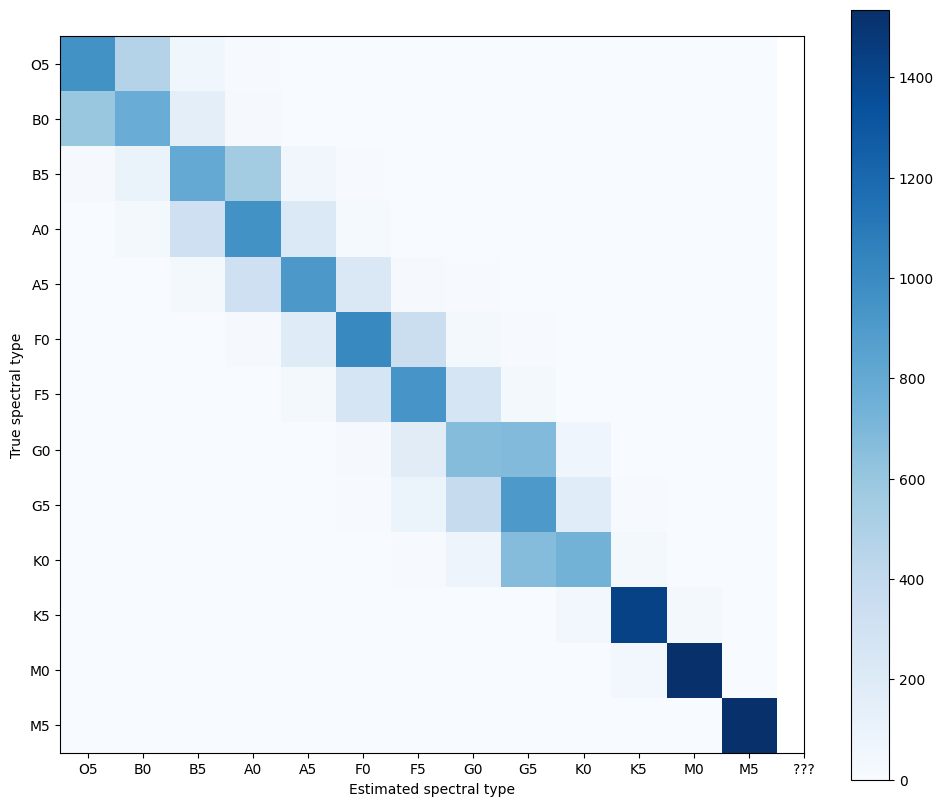

In [21]:
# Plot the confusion matrix

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

plt.figure(figsize= (12,10))
heatmap = plt.imshow(confusion_matrix[:13,:], cmap='Blues')
plt.xticks(np.arange(14), star_class_labels + ['???'])
plt.yticks(np.arange(13), star_class_labels)
plt.colorbar(heatmap)
plt.xlabel("Estimated spectral type")
plt.ylabel("True spectral type")
plt.show()

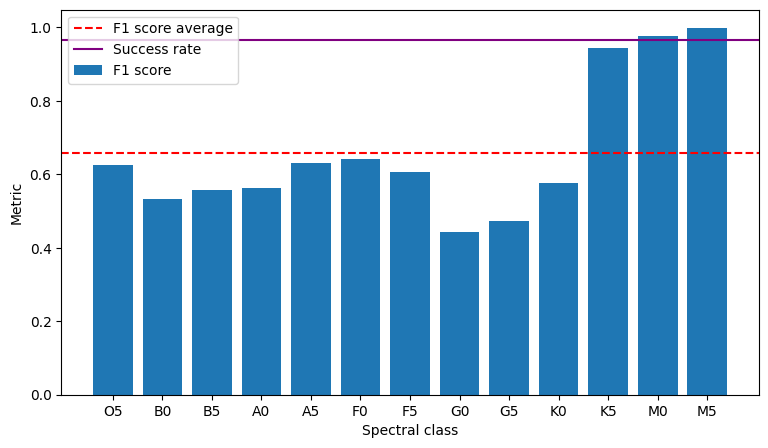

In [22]:
# Plot the metrics

plt.figure(figsize = (9,5))
plt.bar(np.arange(13), height = f1[:13], tick_label = star_class_labels ,label = "F1 score")
plt.axhline(f1_mean, color='red', linestyle='--', label = 'F1 score average')
plt.axhline(success_rate, color='purple', label = 'Success rate')
plt.xlabel("Spectral class")
plt.ylabel("Metric")
plt.legend()

In [ ]:
# PLot the loss function evolution

loss_evolution = learning.history["loss"][10:]
val_loss_evolution = learning.history["val_loss"][10:]

plt.figure(figsize = (9,5))
plt.plot(loss_evolution,label = "Train set")
plt.plot(val_loss_evolution,label = "Validation set")
plt.xlabel("Epochs")
plt.ylabel("Loss function value")
plt.legend()
plt.title("Loss function evolution")
print("Total training time:", training_time, "seconds")
print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])
